In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.applications.resnet50 import decode_predictions,preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

In [70]:
os.getcwd()
os.chdir('C:\\Users\\Harry\\ML practise\\images')

In [78]:
model=tf.keras.applications.resnet50.ResNet50()

In [79]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
lastlayername = "conv5_block3_out"

In [108]:
def classify(path):
    img=image.load_img(path,target_size=(224,224))
    #plt.imshow(img)
    #plt.show()
    display(Image(path))
    imgarr=image.img_to_array(img)
    batchimg=np.expand_dims(imgarr,axis=0)
    ppimg=preprocess_input(batchimg)
    result=model.predict(ppimg)
    print(decode_predictions(result,top=2)[0])
    

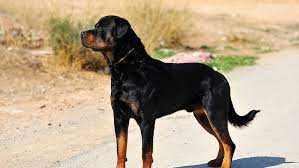

[('n02101006', 'Gordon_setter', 0.8738766), ('n02089078', 'black-and-tan_coonhound', 0.12488436)]


In [109]:
classify('dog.jpg')

In [75]:
from IPython.display import Image, display
import matplotlib.cm as cm

In [84]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [89]:
def makeheatmap(path,last_conv_layer_name):
    refmodel=model
    refmodel.layers[-1].activation = None
    img=image.load_img(path,target_size=(224,224))
    arr=image.img_to_array(img)
    imgarr=np.expand_dims(arr,axis=0)
    heatmap = make_gradcam_heatmap(imgarr,refmodel,last_conv_layer_name)
    plt.matshow(heatmap)
    plt.show()
    return heatmap

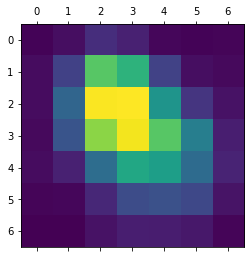

In [90]:
heatmap=makeheatmap('dog.jpg',lastlayername)

In [106]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    #plt.imshow(image.load_img(cam_path,target_size=(224,224)))
    #plt.show()
    display(Image(cam_path))

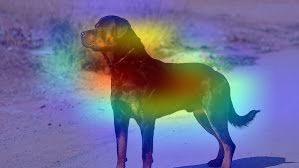

In [111]:
save_and_display_gradcam('dog.jpg', heatmap,alpha=0.95)